In [28]:
import torch
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split


In [29]:
#load in model functions

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

class CustomCNN(nn.Module):
    def __init__(self):
        super(CustomCNN, self).__init__()

        # Define the layers
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)

        # Max pooling layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Fully connected layers
        self.fc1 = nn.Linear(128 * 3 * 3, 256)
        self.fc2 = nn.Linear(256, 29)  # 29 output classes

        # Dropout layer
        self.dropout = nn.Dropout(0.5)

        # Activation function
        self.relu = nn.ReLU()

    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss

    def forward(self, x):
        # First convolution + pooling
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Second convolution + pooling
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        # x = self.dropout(x)

        # Third convolution + pooling
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten the output from the convolutional layers
        x = x.view(-1, 128 * 3 * 3)

        # First fully connected layer
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)

        # Second fully connected layer (output layer)
        x = self.fc2(x)
        return x

    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))


In [30]:
# Load model and data
model = torch.load('trained_model.pth')
data_path = "./dataset/archive/"
test_df = pd.read_csv(data_path+'sign_mnist_test/sign_mnist_test.csv')
X = test_df.drop('label', axis=1).values  # Features - drops the label column and converts to numpy array
y = test_df['label'].values  # Labels
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

In [31]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    non_trainable_params = total_params - trainable_params
    
    print(f"Total parameters: {total_params}")
    print(f"Trainable parameters: {trainable_params}")
    print(f"Non-trainable parameters: {non_trainable_params}")

count_parameters(model)

Total parameters: 395293
Trainable parameters: 395293
Non-trainable parameters: 0


In [32]:
model

CustomCNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1152, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=29, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [33]:
#basic data processing
test_images = test_df.iloc[:, 1:].to_numpy(dtype = 'float32')
test_labels = test_df['label'].values

test_ds = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
test_label_ds = torch.from_numpy(test_labels)

test_ds = TensorDataset(test_ds, test_label_ds)
test_loader = DataLoader(dataset=test_ds, batch_size=32, shuffle=False, num_workers=4)

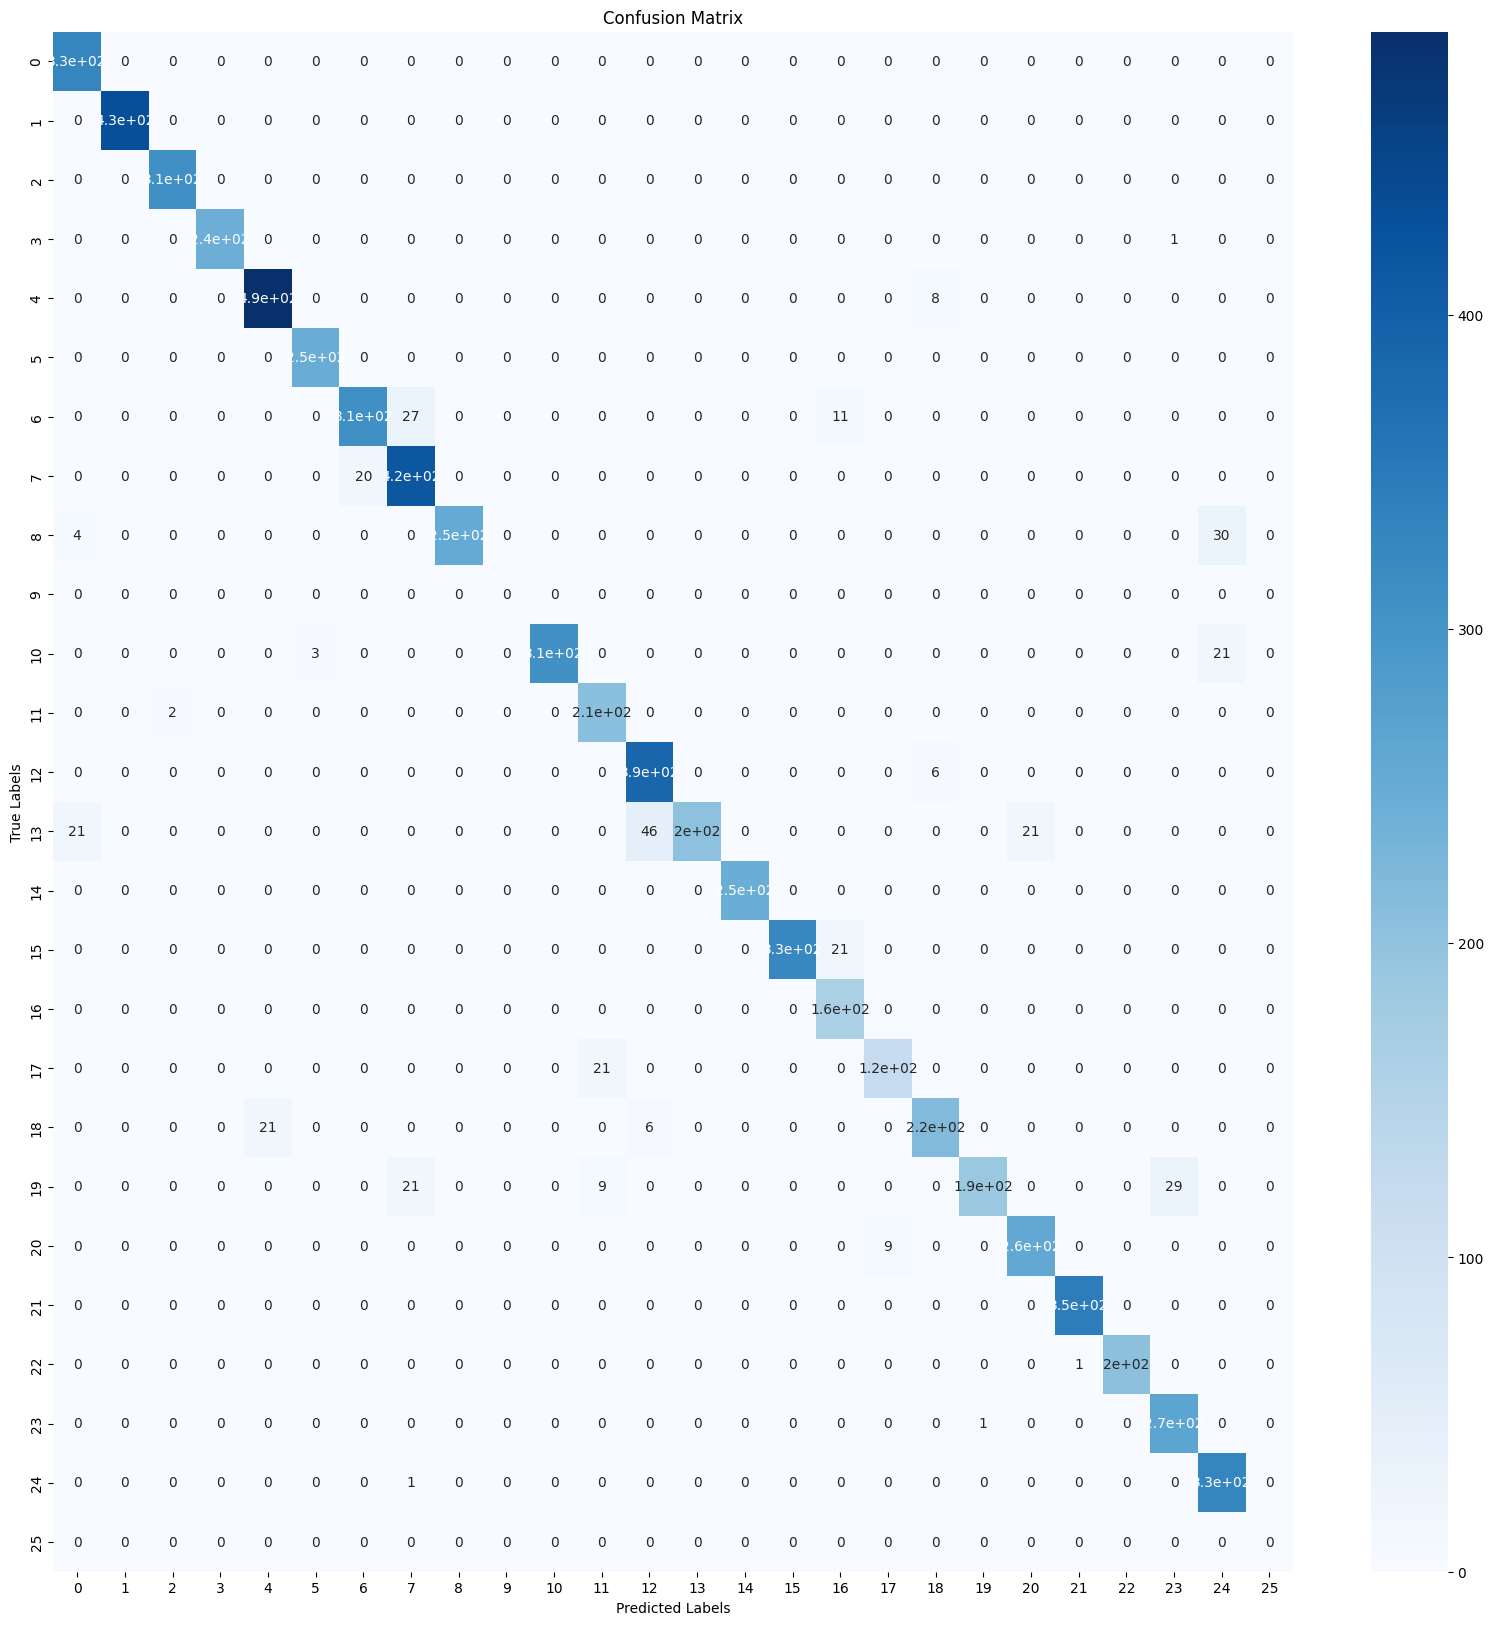

In [34]:
#load in confusion matrix to see what the model confuses the most

def get_predictions(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Get predictions
preds, labels = get_predictions(model, test_loader)

# Compute confusion matrix
conf_mat = confusion_matrix(labels, preds)

row_index = 9
col_index = 9

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

row_index = 25
col_index = 25

# Insert an empty row
empty_row = np.zeros(conf_mat.shape[1])
arr_with_row = np.insert(conf_mat, row_index, empty_row, axis=0)

# Insert an empty column
empty_col = np.zeros(arr_with_row.shape[0])
conf_mat = np.insert(arr_with_row, col_index, empty_col, axis=1)

# Plot confusion matrix heatmap
plt.figure(figsize=(20, 20))
sns.heatmap(conf_mat, annot=True, cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [35]:
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I',
                   9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q',
                   17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
                   25: 'Z'}


# picking the ones with the highest confusion - above 25
true_to_common_confusion = [
                            # (6,7), # also (7, 6)
                            # (6,16), 
                            # (8,24), 
                            # (10,24), 
                            (13, 0),
                            (13,12), 
                            # (13,20), 
                            # (15,16), 
                            # (17,11), 
                            # (18,4),
                            # (19,7), 
                            # (19,23),
                            ]

In [36]:
test_arrays = dict()
for i in range(25):
    if i != 9:
        test_df_a = test_df.loc[test_df['label'] == i]#.sample()
        test_images = test_df_a.iloc[:, 1:].to_numpy(dtype = 'float32')
        test_labels = test_df['label'].values
        test_np = torch.from_numpy(test_images.reshape(test_images.shape[0],1,28,28))
        test_arrays[i] = test_np


# test_df_0 = test_df.loc[test_df['label'] == 0]#.sample()
# test_images_0 = test_df_0.iloc[:, 1:].to_numpy(dtype = 'float32')
# test_labels_0 = test_df_0['label'].values
# test_np_0 = torch.from_numpy(test_images_0.reshape(test_images_0.shape[0],1,28,28))









In [37]:
model.eval()  # Set the model to evaluation mode

# Define the hook function to capture activations
all_activations = {}
activations = {}

def get_activation(name):
    def hook(model, input, output):
        activations[name] = output.detach()
    return hook

hook = model.fc1.register_forward_hook(get_activation('fc1'))

#get model activations for all the negative and postive examples we want to pull
for i in range(25):
    if i != 9:
        output = model(test_arrays[i])
        all_activations[i] = activations['fc1']


# Unregister the hook
hook.remove()
# print(all_activations)

In [38]:
all_activations

{0: tensor([[ 9.1422e+00, -2.9861e-14, -2.3013e-09,  ..., -3.1826e+00,
          -8.9617e-03, -1.4541e-07],
         [ 8.1924e+00, -1.1467e-13, -2.1597e-09,  ..., -1.9999e+00,
          -8.9087e-03, -1.4851e-07],
         [ 1.0993e+01, -8.5605e-14, -1.4727e-09,  ..., -3.1651e+00,
          -8.7588e-03, -1.1201e-07],
         ...,
         [ 3.9198e+00, -5.2248e-14, -1.9965e-09,  ..., -2.7839e+00,
          -9.3026e-03, -1.3668e-07],
         [ 6.3921e+00, -7.7853e-14, -2.0613e-09,  ..., -1.9116e+00,
          -6.8391e-03, -1.3502e-07],
         [ 1.5572e+01, -9.1797e-14, -1.7659e-09,  ..., -2.9049e+00,
          -9.1288e-03, -1.3010e-07]]),
 1: tensor([[ 4.4218e+00, -1.1830e-13, -7.8236e-10,  ..., -7.6181e-01,
          -2.9749e-03, -5.9699e-08],
         [ 6.7525e+00, -1.0674e-13, -6.5384e-10,  ..., -1.3827e+00,
          -3.7739e-03, -5.3339e-08],
         [ 1.1540e+01, -1.6023e-13, -2.2410e-09,  ..., -2.1431e+00,
          -7.7638e-03, -1.5200e-07],
         ...,
         [ 8.3580e+

In [39]:

#format the activations to run PCA
formatted_activations = torch.cat([all_activations[key] for key in all_activations], dim=0)

labels_activations = torch.cat([key*torch.ones(all_activations[key].size(0)) for key in all_activations])


In [40]:
formatted_activations

tensor([[ 9.1422e+00, -2.9861e-14, -2.3013e-09,  ..., -3.1826e+00,
         -8.9617e-03, -1.4541e-07],
        [ 8.1924e+00, -1.1467e-13, -2.1597e-09,  ..., -1.9999e+00,
         -8.9087e-03, -1.4851e-07],
        [ 1.0993e+01, -8.5605e-14, -1.4727e-09,  ..., -3.1651e+00,
         -8.7588e-03, -1.1201e-07],
        ...,
        [-2.0555e-01, -9.2362e-14, -1.7522e-09,  ..., -1.5955e+00,
         -6.6113e-03, -1.1794e-07],
        [-3.9325e-01, -8.7284e-14, -1.8781e-09,  ..., -1.9593e+00,
         -7.5973e-03, -1.2562e-07],
        [-1.3812e-01, -7.0970e-14, -1.8823e-09,  ..., -2.4245e+00,
         -8.2890e-03, -1.2531e-07]])

In [41]:
labels_activations

tensor([ 0.,  0.,  0.,  ..., 24., 24., 24.])

pairs with confusion: [(13, 0), (13, 12)]
no confusion examples: [(0, 15), (0, 22)]


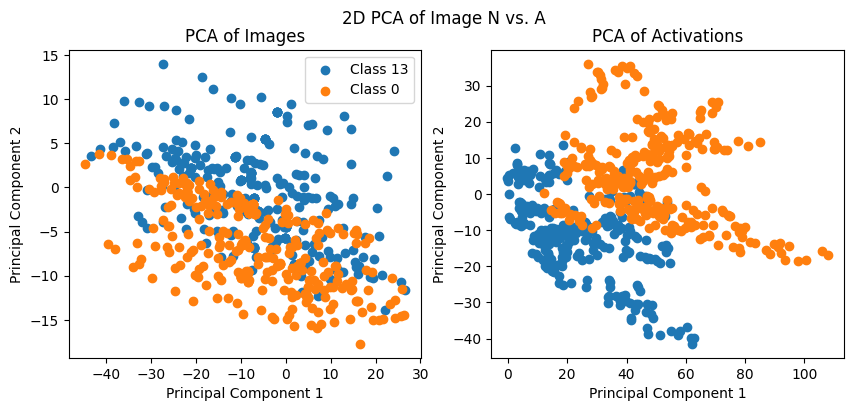

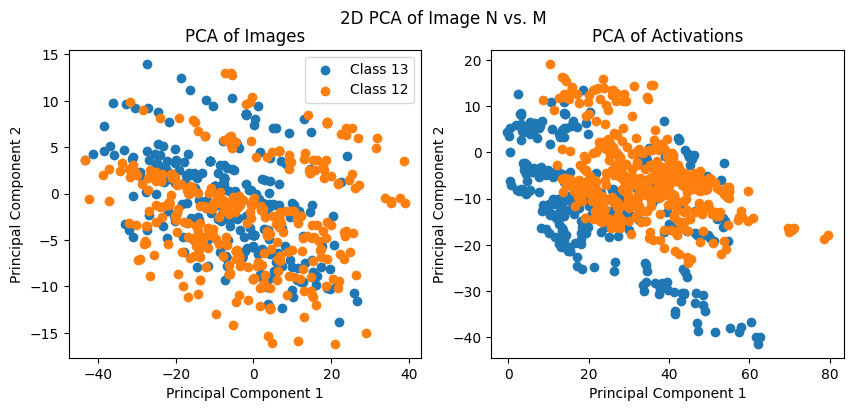

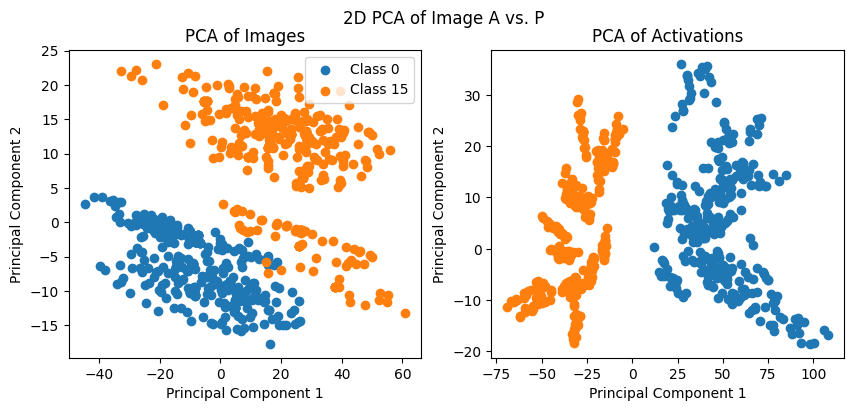

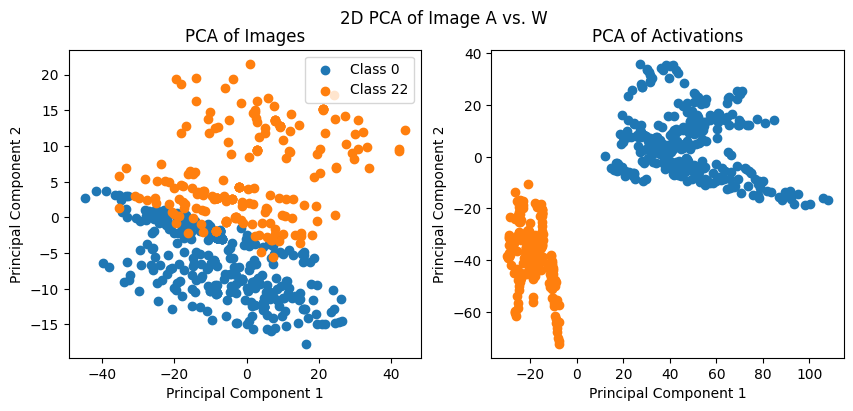

In [52]:
#PCA run on all the different classes
negative_examples = [(0,15),
                     (0,22)]
pairs_to_analyze = true_to_common_confusion + negative_examples

print(f'pairs with confusion: {true_to_common_confusion}')
print(f'no confusion examples: {negative_examples}')

pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_standardized)
activations_pca = pca.fit_transform(formatted_activations)

# Visualization
for pair in pairs_to_analyze:
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y == target, 0], 
                    principal_components[y == target, 1], 
                    label=f"Class {target}")
        ax[1].scatter(activations_pca[labels_activations == target, 0], 
                    activations_pca[labels_activations == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

pairs with confusion: [(13, 0), (13, 12)]
no confusion examples: [(0, 15), (0, 22)]


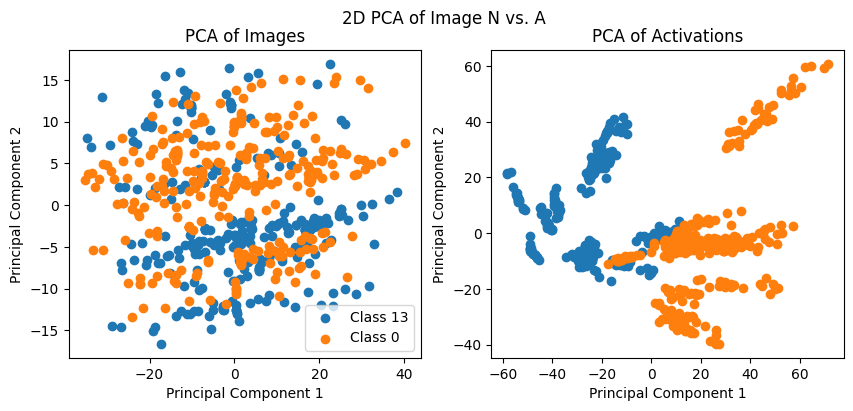

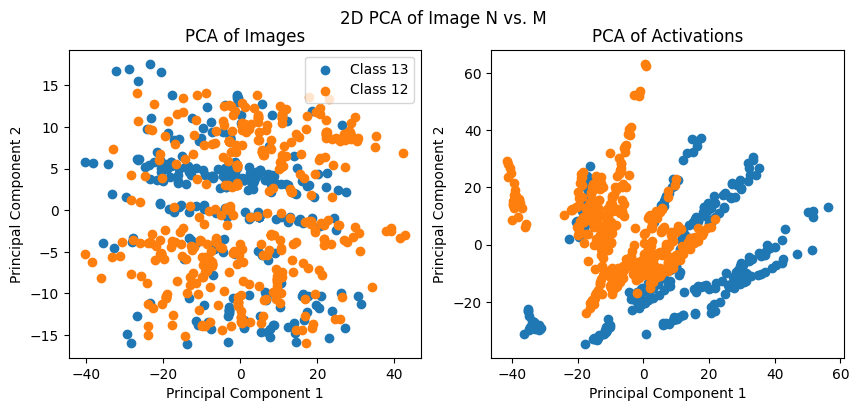

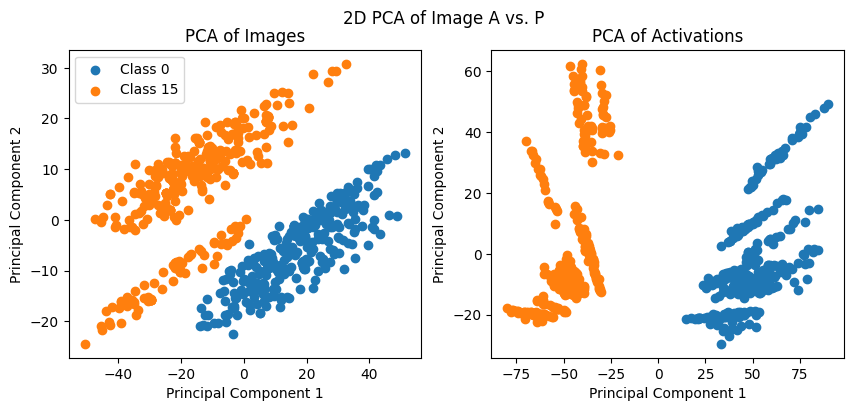

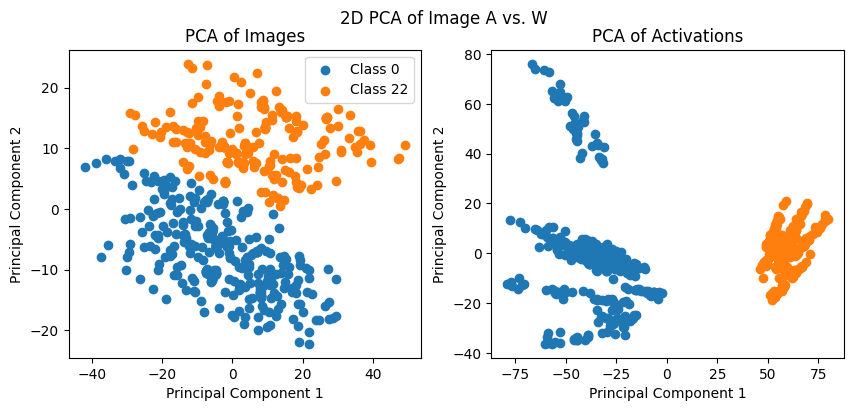

In [54]:
#PCA running on only the pairs
print(f'pairs with confusion: {true_to_common_confusion}')
print(f'no confusion examples: {negative_examples}')
pca = PCA(n_components=2)


# Visualization
for pair in pairs_to_analyze:
    mask = np.logical_or.reduce([y == label for label in pair])
    # Filter the data using the mask
    X_stan_filtered = X_standardized[mask]
    y_filtered = y[mask]
    mask_act = np.logical_or.reduce([labels_activations == label for label in pair])
    filtered_activations = formatted_activations[mask_act]
    labels_act_filtered = labels_activations[mask_act]
    principal_components = pca.fit_transform(X_stan_filtered)
    activations_pca = pca.fit_transform(filtered_activations)

    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y_filtered == target, 0], 
                    principal_components[y_filtered == target, 1], 
                    label=f"Class {target}")
        
        ax[1].scatter(activations_pca[labels_act_filtered == target, 0], 
                    activations_pca[labels_act_filtered == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 685 but corresponding boolean dimension is 7172

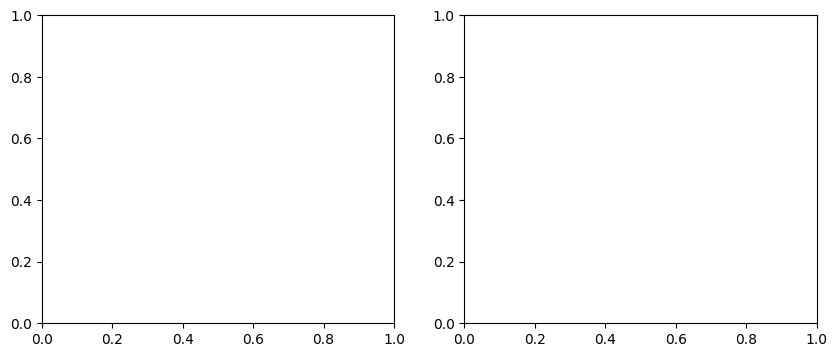

In [ ]:
negative_examples = [(0,15),
                     (0,22)]

for pair in negative_examples:    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    for i, target in enumerate(pair):
        ax[0].scatter(principal_components[y == target, 0], 
                    principal_components[y == target, 1], 
                    label=f"Class {target}")
        ax[1].scatter(activations_pca[labels_activations == target, 0], 
                    activations_pca[labels_activations == target, 1], 
                    label=f"Class {target}")

    ax[0].legend()
    ax[0].set_xlabel("Principal Component 1")
    ax[0].set_ylabel("Principal Component 2")
    ax[0].set_title('PCA of Images')
    ax[1].set_xlabel("Principal Component 1")
    ax[1].set_ylabel("Principal Component 2")
    ax[1].set_title('PCA of Activations')
    fig.suptitle(f"2D PCA of Image {index_to_letter[pair[0]]} vs. {index_to_letter[pair[1]]}")
    plt.show()

